# IMPORTS

In [198]:
!pip install powerlaw

In [199]:

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict

import numpy as np

import powerlaw
from scipy.special import factorial
from tqdm import tqdm
from collections import Counter

import math

In [200]:
def read_gml_graph(gml_file):
    try:
        # Read the GML file
        G = nx.read_gml(gml_file)
        print(f"Graph loaded successfully:")
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        return G
    except Exception as e:
        print(f"Error reading GML file: {str(e)}")
        return None



In [201]:
def read_graphml(graphml_file):
    try:
        # Read the GraphML file
        G = nx.read_graphml(graphml_file)
        print(f"Graph loaded successfully:")
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        return G
    except Exception as e:
        print(f"Error reading GraphML file: {str(e)}")
        return None



In [202]:


G_eco = read_gml_graph("knn_network.gml")

Graph loaded successfully:
Number of nodes: 399
Number of edges: 1747


In [203]:
G_morpho = read_graphml("morphological_parrot_network.graphml")

Graph loaded successfully:
Number of nodes: 398
Number of edges: 1372


In [204]:
def analyze_connectivity(net1, net2, name1="Network 1", name2="Network 2"):
    # Check if networks are connected
    is_connected1 = nx.is_connected(net1)
    is_connected2 = nx.is_connected(net2)

    print(f"\n{name1} is {'connected' if is_connected1 else 'not connected'}")
    print(f"{name2} is {'connected' if is_connected2 else 'not connected'}")

    # If not connected, analyze components
    if not is_connected1:
        components1 = list(nx.connected_components(net1))
        print(f"\n{name1} components:")
        print(f"Number of components: {len(components1)}")
        print(f"Sizes of components: {[len(c) for c in components1]}")

    if not is_connected2:
        components2 = list(nx.connected_components(net2))
        print(f"\n{name2} components:")
        print(f"Number of components: {len(components2)}")
        print(f"Sizes of components: {[len(c) for c in components2]}")

    # Get largest component for each network
    largest_cc1 = max(nx.connected_components(net1), key=len)
    largest_cc2 = max(nx.connected_components(net2), key=len)

    print(f"\nLargest component sizes:")
    print(f"{name1}: {len(largest_cc1)} nodes ({len(largest_cc1)/net1.number_of_nodes()*100:.1f}% of network)")
    print(f"{name2}: {len(largest_cc2)} nodes ({len(largest_cc2)/net2.number_of_nodes()*100:.1f}% of network)")

# Analyze connectivity
analyze_connectivity(G_eco, G_morpho, "Ecological Network", "Morphological Network")


Ecological Network is not connected
Morphological Network is connected

Ecological Network components:
Number of components: 9
Sizes of components: [18, 33, 100, 30, 177, 18, 6, 9, 8]

Largest component sizes:
Ecological Network: 177 nodes (44.4% of network)
Morphological Network: 398 nodes (100.0% of network)


In [205]:
def plot_network_comparison_with_degree_dist(G1, G2, pos1=None, pos2=None, title1="Ecological Network", title2="Morphological Network"):
    """
    Create scatter plots of two networks side by side with degree distributions showing P(k).
    """
    # Create a figure with four subplots
    fig = plt.figure(figsize=(15, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Generate positions if not provided
    if pos1 is None:
        pos1 = nx.spring_layout(G1)
    if pos2 is None:
        pos2 = nx.spring_layout(G2)

    # Plot first network
    nx.draw_networkx_edges(G1, pos1, alpha=0.2, ax=ax1)
    nodes1 = nx.draw_networkx_nodes(G1, pos1,
                                  node_size=50,
                                  node_color=[G1.degree(node) for node in G1.nodes()],
                                  cmap=plt.cm.viridis,
                                  ax=ax1)
    ax1.set_title(f"{title1}\nNodes: {G1.number_of_nodes()}, Edges: {G1.number_of_edges()}")

    # Plot second network
    nx.draw_networkx_edges(G2, pos2, alpha=0.2, ax=ax2)
    nodes2 = nx.draw_networkx_nodes(G2, pos2,
                                  node_size=50,
                                  node_color=[G2.degree(node) for node in G2.nodes()],
                                  cmap=plt.cm.viridis,
                                  ax=ax2)
    ax2.set_title(f"{title2}\nNodes: {G2.number_of_nodes()}, Edges: {G2.number_of_edges()}")

    # Add colorbars
    plt.colorbar(nodes1, ax=ax1, label='Node Degree')
    plt.colorbar(nodes2, ax=ax2, label='Node Degree')

    # Calculate degree distributions in terms of probability
    def get_degree_probability(G):
        degrees = [d for n, d in G.degree()]
        # Count frequency of each degree
        degree_count = Counter(degrees)
        # Calculate probability
        total_nodes = len(G.nodes())
        degree_prob = {k: v/total_nodes for k, v in degree_count.items()}
        return degree_prob

    degree_prob1 = get_degree_probability(G1)
    degree_prob2 = get_degree_probability(G2)

    # Plot degree distributions
    # Network 1 degree distribution
    ax3.bar(degree_prob1.keys(), degree_prob1.values(), alpha=0.7)
    ax3.set_title(f'{title1} Degree Distribution')
    ax3.set_xlabel('Degree (k)')
    ax3.set_ylabel('P(k)')

    # Network 2 degree distribution
    ax4.bar(degree_prob2.keys(), degree_prob2.values(), alpha=0.7)
    ax4.set_title(f'{title2} Degree Distribution')
    ax4.set_xlabel('Degree (k)')
    ax4.set_ylabel('P(k)')

    # Remove axis from network plots
    ax1.set_axis_off()
    ax2.set_axis_off()

    plt.tight_layout()
    plt.show()

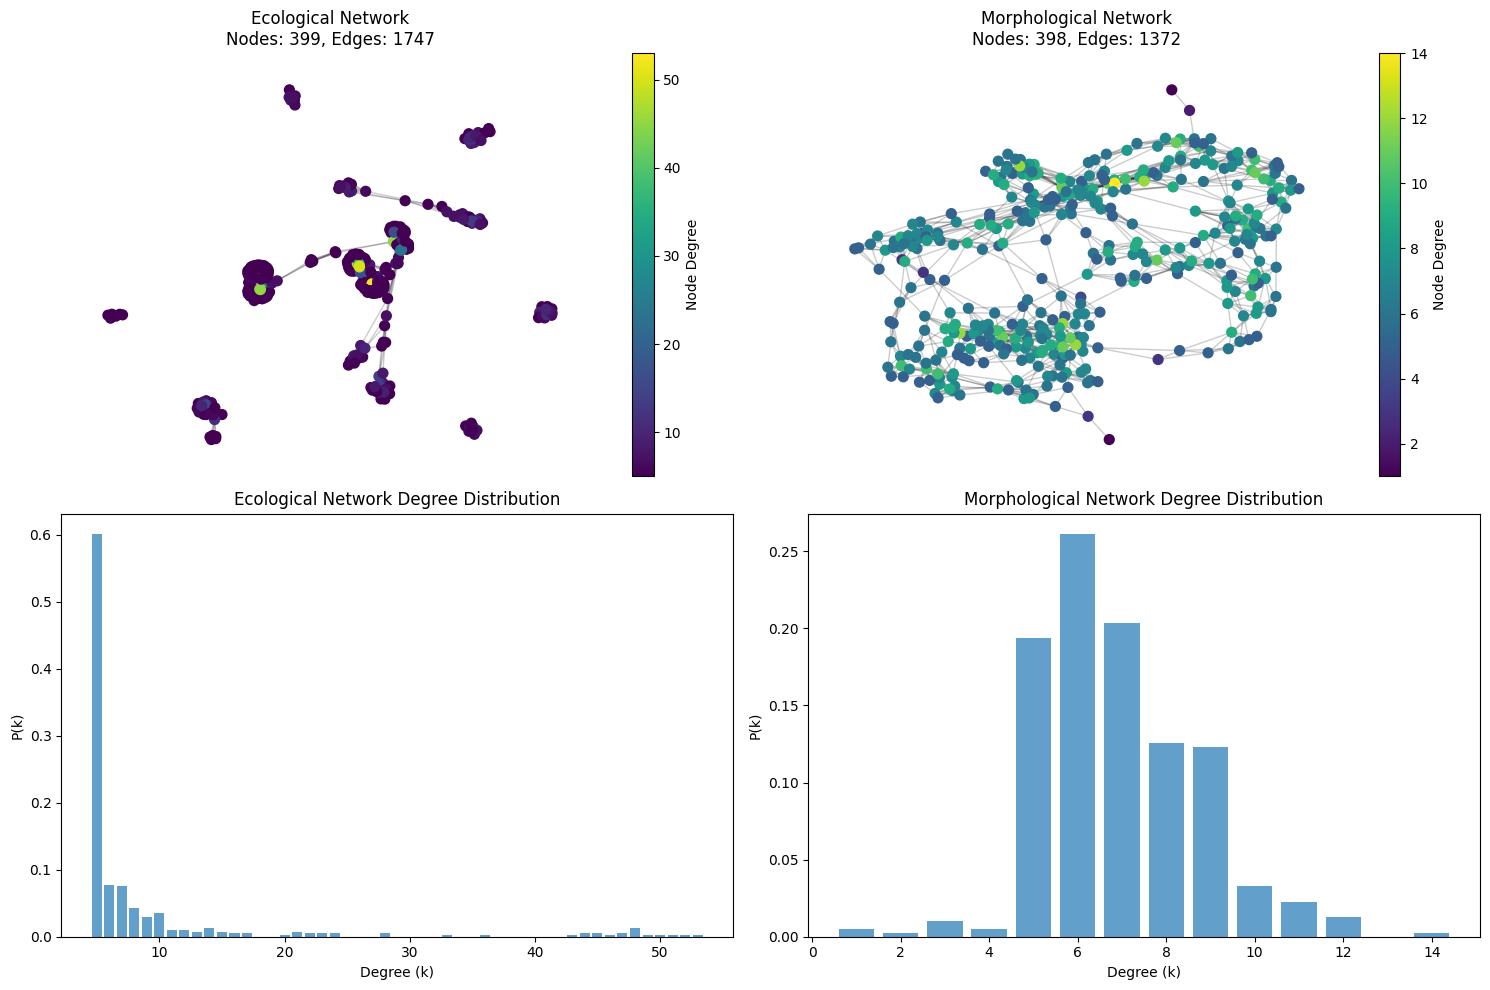

In [206]:
plot_network_comparison_with_degree_dist(G_eco, G_morpho)

 The ecological network shows a classic power-law-like distribution, where about 60% of the species have very few connections, while a small minority serve as highly connected hubs with up to 50 connections. This pattern is typical in interaction networks, such as those representing feeding relationships, where most species are specialists and few species are generalists that interact with many others.


 In contrast, the morphological network, which connects parrots based on shared physical traits, displays a more bell-shaped distribution. Here, the connections are more evenly distributed - most species share similarities with a moderate number of others.

 This difference in distributions reflects the underlying processes: ecological interactions tend to create specialized relationships with a few key hub species, while morphological traits tend to be shared more uniformly across related species due to their common evolutionary history. The morphological network thus reveals the underlying similarity structure of parrot species, while the ecological network captures the more hierarchical nature of their interactions.

In [207]:
def average_neighbor_degree_by_degree(G):
    # Get average neighbor degree for each node
    avg_neighbor_degrees = nx.average_neighbor_degree(G)

    # Group by degree
    degree_to_knn = {}
    for node, k_nn in avg_neighbor_degrees.items():
        k = G.degree(node)
        if k not in degree_to_knn:
            degree_to_knn[k] = []
        degree_to_knn[k].append(k_nn)

    # Convert to lists for plotting
    degrees = []
    knn_values = []
    for k in sorted(degree_to_knn.keys()):
        for knn in degree_to_knn[k]:
            degrees.append(k)
            knn_values.append(knn)

    return degrees, knn_values

def plot_knn_k(G1, G2, title="Networks Comparison"):
    # Calculate k_nn(k) for both networks
    k1, knn1 = average_neighbor_degree_by_degree(G1)
    k2, knn2 = average_neighbor_degree_by_degree(G2)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot points for both networks
    plt.scatter(k1, knn1, c='red', alpha=0.6, label='Ecological')
    plt.scatter(k2, knn2, c='blue', alpha=0.6, label='Morphological')

    plt.xlabel('k')
    plt.ylabel('k$_{nn}$(k)')
    plt.title(title)
    plt.legend()

    plt.show()

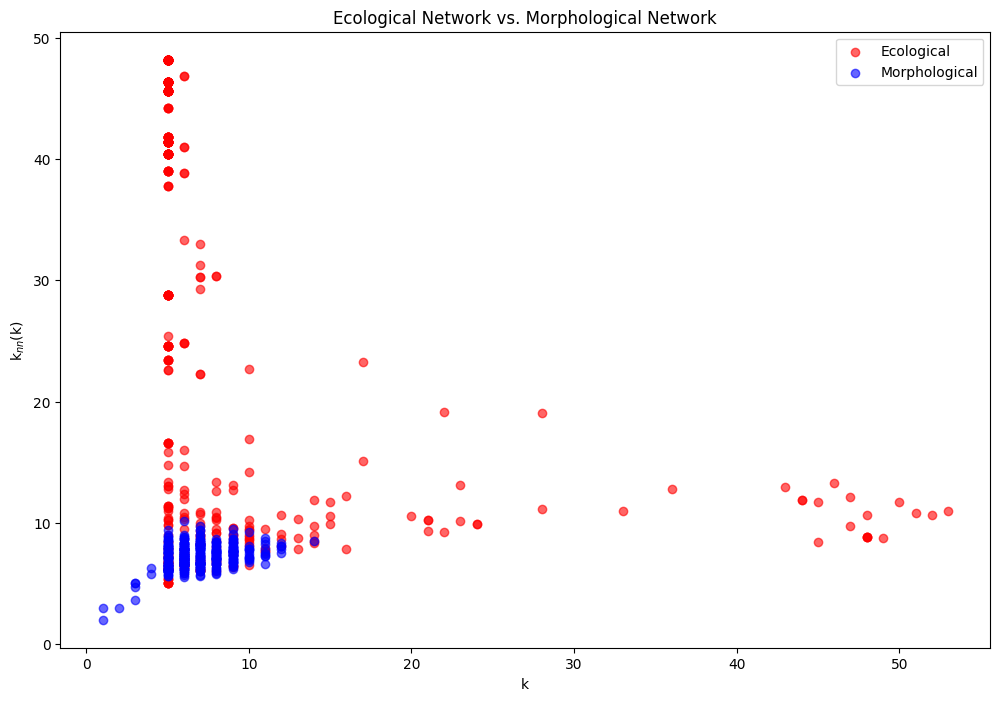

In [208]:
plot_knn_k(G_eco, G_morpho, title="Ecological Network vs. Morphological Network")

If the average degree of neighbors decreases as the degree of a node increases, this suggests disassortative mixing or negative assortativity.We observe this pattern in the ecological network.


The ecological network appears to have a structure that supports a wide range of interaction levels, indicative of a complex system with potential for specialization and generalization among species.

The morphological network, with its more concentrated degree distribution, suggests a network where evolutionary processes have led to a more uniform distribution of traits.

**INFO **

**Conservation and Management:** In ecological networks, knowing whether the network is assortative or disassortative can guide conservation strategies, focusing on protecting highly connected species if they are crucial for network integrity or targeting species that bridge different parts of the network if they are key for connectivity.

# Assortativity Analysis

**Disassortativity** in network analysis refers to a pattern where nodes with high degrees (many connections) tend to connect to nodes with low degrees (few connections), rather than to other high-degree nodes.

In [209]:
def comprehensive_assortativity(G, node_attributes=None):
    """
    Calculate multiple assortativity measures for a network

    Parameters:
    G : networkx graph
    node_attributes : dict of node attributes (optional)
        Format: {'attribute_name': {node_id: value}}
    """
    results = defaultdict(float)

    # 1. Structural Assortativity
    try:
        results['degree'] = nx.degree_assortativity_coefficient(G)
    except:
        results['degree'] = np.nan

    # Calculate clustering for each node
    clustering = nx.clustering(G)
    nx.set_node_attributes(G, clustering, 'clustering')
    try:
        results['clustering'] = nx.attribute_assortativity_coefficient(G, 'clustering')
    except:
        results['clustering'] = np.nan

    # Betweenness centrality
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G, betweenness, 'betweenness')
    try:
        results['betweenness'] = nx.attribute_assortativity_coefficient(G, 'betweenness')
    except:
        results['betweenness'] = np.nan


    return dict(results)

def print_assortativity_results(results):
    """Pretty print assortativity results with interpretations"""
    print("Network Assortativity Analysis")
    print("-" * 50)

    for measure, value in results.items():
        print(f"\n{measure.title()} Assortativity: {value:.3f}")

        # Interpretation
        if np.isnan(value):
            print("  Unable to calculate")
        elif value > 0.3:
            print("  Strong positive association")
        elif value > 0.1:
            print("  Moderate positive association")
        elif value > -0.1:
            print("  Weak or random association")
        elif value > -0.3:
            print("  Moderate negative association")
        else:
            print("  Strong negative association")







## Morphological Network

In [210]:
results = comprehensive_assortativity(G_morpho, node_attributes={'type': dict(G_morpho.nodes())})
print_assortativity_results(results)

Network Assortativity Analysis
--------------------------------------------------

Degree Assortativity: 0.129
  Moderate positive association

Clustering Assortativity: 0.013
  Weak or random association

Betweenness Assortativity: 0.002
  Weak or random association


**Low Assortativity (0.129):** This metric reveals that species with a high number of shared traits do not exclusively connect with each other but also with species that share fewer traits. This pattern suggests a diversity in trait distribution across species.

**Clustering Assortativity (0.013):** The low clustering coefficient in the morphological connection network suggests that there isn't a strong tendency for species with similar trait profiles to form tight clusters. This supports the idea of mosaic evolution where:
* 	Species can evolve traits independently without a strong correlation with other traits, leading to a more scattered network structure.
* 	This indicates flexibility in evolutionary pathways, allowing for the independent evolution of different traits.

**Betweenness Assortativity (0.002):** The near-zero betweenness assortativity shows that species that act as bridges in the network (connecting different clusters) do so randomly, not based on their degree of trait sharing. This suggests:
*	Evolutionary innovations or trait sharing can occur across diverse lineages, facilitating the mixing and matching of traits.
*	It supports the idea that evolutionary bridges are not defined by the number of traits shared but by the diversity of connections, allowing for a broad exploration of the trait space.

**Conclusion:**
* Trait Independence: The network structure indicates that while some traits are conserved across many species, others can rapidly diversify, leading to unique adaptations without necessarily affecting other traits.
* Evolutionary Flexibility: The lack of strong clustering and random bridge species suggests that parrots can adapt to new environments or ecological niches through the independent evolution of specific traits.


## Ecological Network

In [211]:
results = comprehensive_assortativity(G_eco, node_attributes={'type': dict(G_eco.nodes())})
print_assortativity_results(results)

Network Assortativity Analysis
--------------------------------------------------

Degree Assortativity: -0.362
  Strong negative association

Clustering Assortativity: 0.002
  Weak or random association

Betweenness Assortativity: 0.002
  Weak or random association


**Degree assortativity(-0.362)**
* Disassortativity implies that parrots with many connections (high degree) are more likely to interact with those that have fewer connections (low degree). This could mean that species with broad ecological roles or wide-ranging habitats (generalists) are more likely to interact with species that have narrower roles or more specific habitat requirements (specialists).

* Even without direct geographic overlap, species might occupy similar ecological niches in different locations, leading to similar ecological roles. This could result in a form of ecological redundancy or complementarity across different ecosystems, where similar roles are filled by different species.

* In terms of trophic niches, disassortative might indicate that species with broad diets (generalists) interact with those having specific diets (specialists), potentially leading to complex food web structures.

* A disassortative network might be more resilient to disturbances. If highly connected species (hubs) are removed, the network doesn't collapse because these species are connected to less connected ones, which might still maintain network integrity. This resilience is crucial for ecosystem stability, particularly in the face of environmental changes, habitat loss, or species extinctions.

* Generalist species might facilitate resource sharing by interacting with specialists, potentially reducing competition in specific niches. This interaction could help in stabilizing the ecosystem by allowing for distribution of resources.

* Such a disassortative network structure might mitigate the effects of resource scarcity in certain habitats or during certain times by allowing species with different dietary needs or habitat preferences to coexist or even support each other through indirect means.


**Clustering Assortativity(0.002)**

* Weak clustering can indicate a flexible community structure where species can adapt to changes in the environment or in species composition without significant disruption to the overall network.

* This might also suggest that both generalist and specialist species interact in ways that do not form tight-knit communities based on their interaction patterns, potentially allowing for more dynamic ecological roles and interactions.


# Betweennes Centrality

**Betweenness Centrality**
Measures species' role as connectors

**Critical for:**
* Identifying key species
* Understanding energy flow pathways
* Network cohesion
* High betweenness: species that connect different communities or trophic levels

In [212]:
def get_top_betweenness_nodes(G, n_top=10):
    # Calculate betweenness centrality
    betweenness_dict = nx.betweenness_centrality(G)

    # Convert to dataframe for easy sorting
    df = pd.DataFrame.from_dict(betweenness_dict,
                               orient='index',
                               columns=['betweenness'])

    # Sort and get top n nodes
    top_nodes = df.sort_values('betweenness',
                              ascending=False).head(n_top)

    return top_nodes

In [213]:
def plot_network_betweenness(G, top_n=10):
    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(G)

    # Get connected components and create a unified layout
    components = list(nx.connected_components(G))
    pos = {}

    # Position each component separately
    for i, comp in enumerate(components):
        subgraph = G.subgraph(comp)
        # Create layout for each component
        comp_pos = nx.spring_layout(subgraph, k=1, iterations=50)

        # Offset each component position
        # Arrange components in a grid-like pattern
        row = i // 4  # 4 components per row
        col = i % 4
        offset = np.array([col * 4, -row * 4])

        # Add positioned nodes to main position dictionary
        pos.update({node: pos + offset for node, pos in comp_pos.items()})

    plt.figure(figsize=(12,8))

    # Plot nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_color=[betweenness[node] for node in G.nodes()],
                                 node_size=[v * 3000 for v in betweenness.values()],
                                 cmap=plt.cm.viridis)

    # Plot edges within components
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add labels for top nodes
    top_nodes = dict(sorted(betweenness.items(),
                          key=lambda x: x[1],
                          reverse=True)[:top_n])
    nx.draw_networkx_labels(G, pos,
                          {node: node for node in top_nodes.keys()},
                          font_size=8)

    # Add colorbar
    plt.colorbar(nodes, label='Betweenness Centrality')

    plt.title(f"Ecological Network\nNodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    plt.axis('off')
    plt.margins(0.3)  # Add more margin to prevent cutoff
    plt.tight_layout()
    plt.show()

## Ecological Network

In [170]:
get_top_betweenness_nodes(G_eco)

,betweenness
Aratinga auricapillus,0.112121
Nestor meridionalis,0.061948
Enicognathus leptorhynchus,0.048188
Polytelis swainsonii,0.048188
Myiopsitta luchsi,0.044133
Pyrrhura pfrimeri,0.034960
Bolborhynchus lineola,0.034884
Touit batavicus,0.030386
Touit stictopterus,0.030386
Platycercus eximius,0.030302


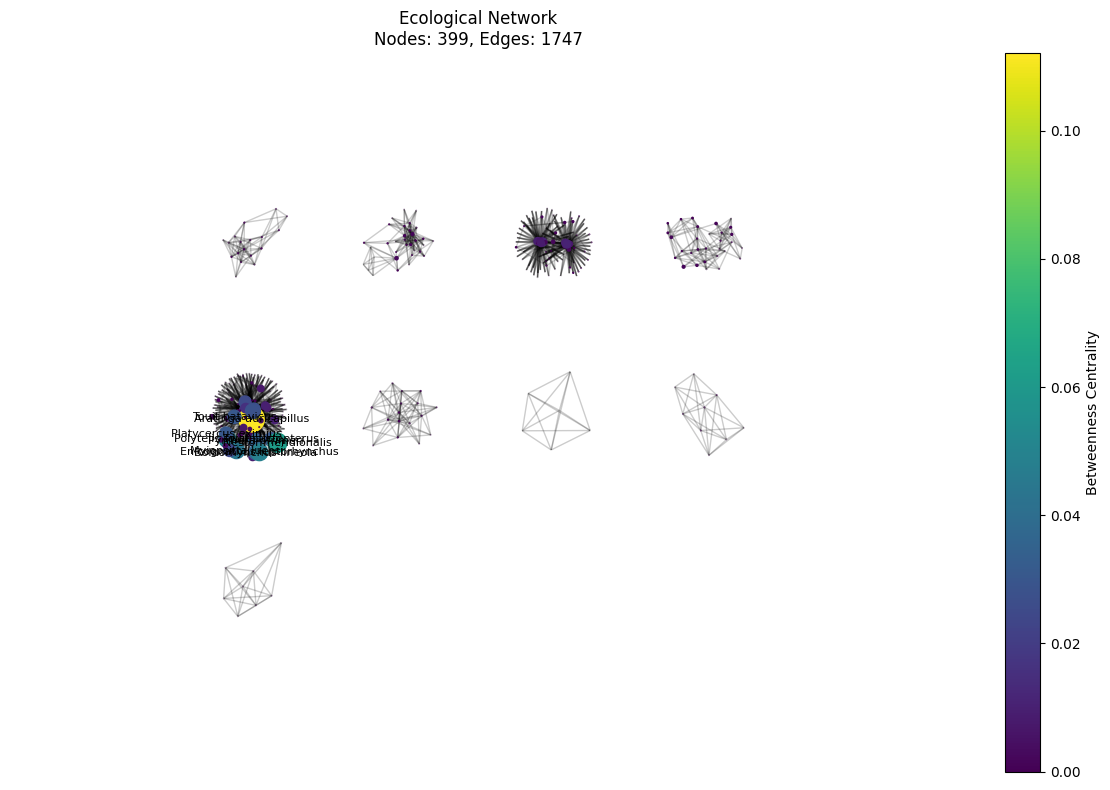

In [171]:
plot_network_betweenness(G_eco)

In [214]:
def plot_largest_component(G):
    # Get the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc)

    # Calculate betweenness for the largest component
    betweenness = nx.betweenness_centrality(G)

    # Create layout with more spacing
    pos = nx.fruchterman_reingold_layout(G_largest,
                                       k=1.5,  # node distance
                                       iterations=100,  # more iterations for better convergence
                                       seed=42)  # for reproducibility

    plt.figure(figsize=(15,10))  # larger figure size

    # Plot nodes
    nodes = nx.draw_networkx_nodes(G_largest, pos,
                                 node_color=[betweenness[node] for node in G_largest.nodes()],
                                 node_size=300,  # fixed node size
                                 cmap=plt.cm.viridis)

    # Plot edges
    nx.draw_networkx_edges(G_largest, pos, alpha=0.2)

    # Get top 10 nodes by betweenness centrality
    top_nodes = dict(sorted([(node, betweenness[node]) for node in G_largest.nodes()],
                          key=lambda x: x[1],
                          reverse=True)[:10])

    # Add labels only for top nodes
    nx.draw_networkx_labels(G_largest, pos,
                          {node: node for node in top_nodes.keys()},
                          font_size=8,
                          font_weight='bold')

    # Add colorbar
    plt.colorbar(nodes, label='Betweenness Centrality')

    plt.title(f"Largest Component of Ecological Network\nNodes: {G_largest.number_of_nodes()}, Edges: {G_largest.number_of_edges()}")
    plt.axis('off')
    plt.tight_layout()

    # Add more margin around the plot
    plt.margins(x=0.2, y=0.2)
    plt.show()

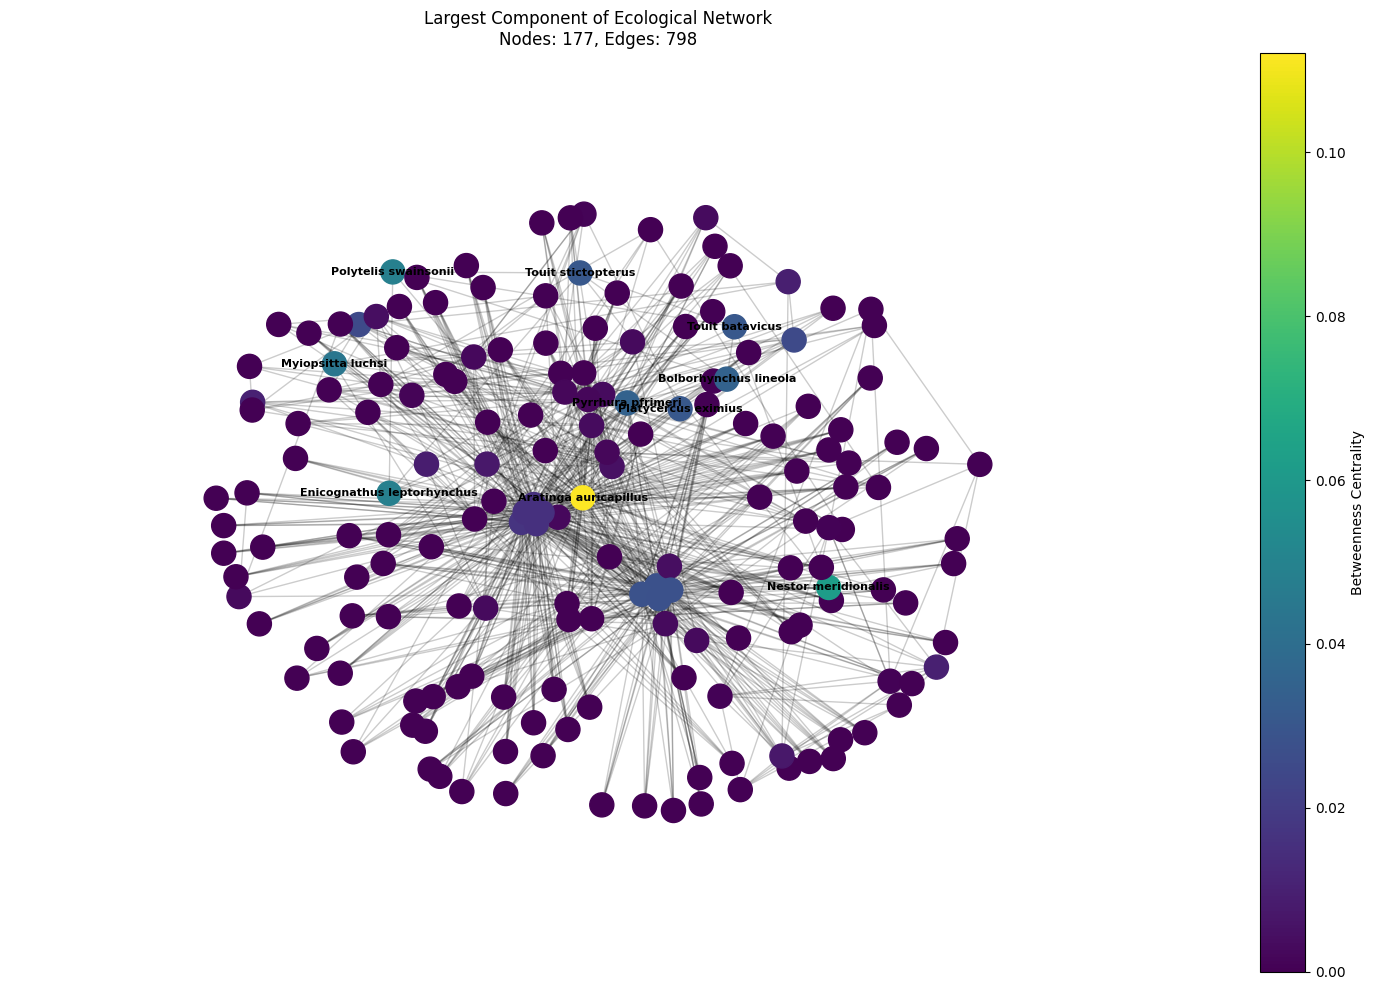

In [173]:
plot_largest_component(G_eco)

##Morphological Network

In [174]:
get_top_betweenness_nodes(G_morpho)

,betweenness
Pezoporus occidentalis,0.146810
Cyanoramphus unicolor,0.137933
Chalcopsitta duivenbodei,0.135661
Pezoporus wallicus,0.126747
Northiella haematogaster,0.097588
Cyanoramphus malherbi,0.090827
Eunymphicus uvaeensis,0.079553
Nestor meridionalis,0.071746
Cyanoramphus novaezelandiae,0.066056
Trichoglossus capistratus,0.063203


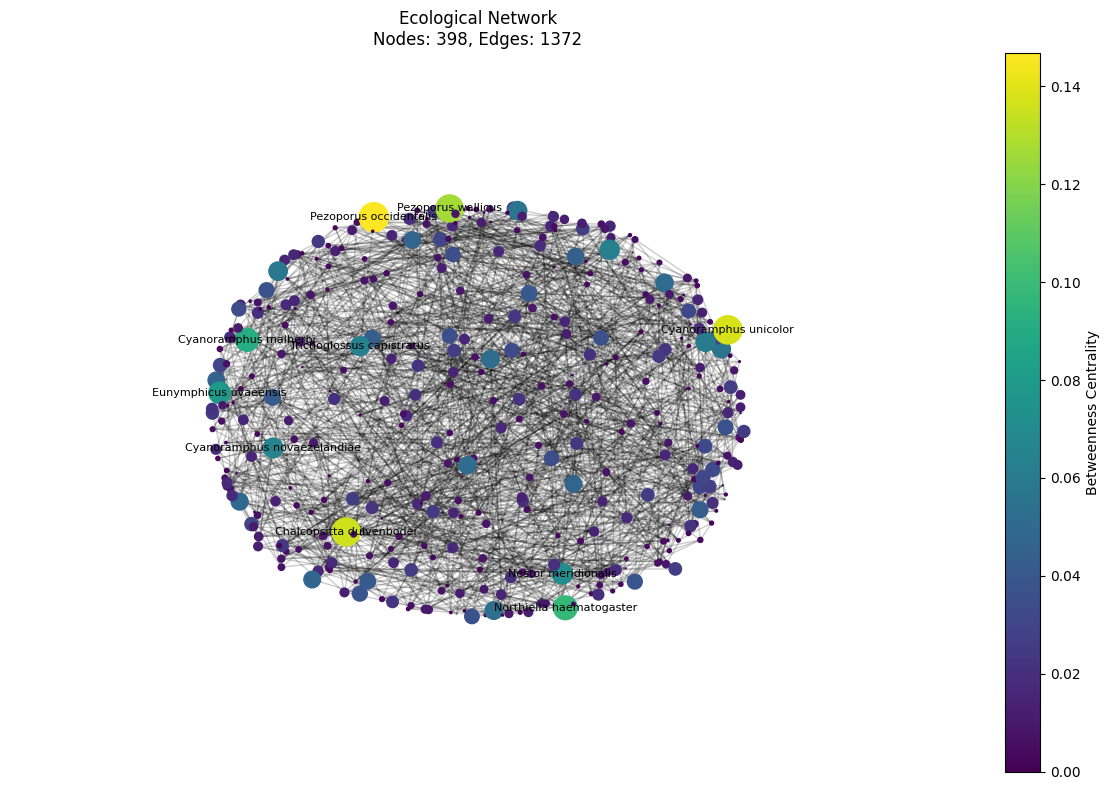

In [175]:
plot_network_betweenness(G_morpho)

# Closeness Centrality

In [176]:
def get_top_closeness_nodes(G, n_top=10):
    # Calculate closeness centrality
    closeness_dict = nx.closeness_centrality(G)

    # Convert to dataframe for easy sorting
    df = pd.DataFrame.from_dict(closeness_dict,
                               orient='index',
                               columns=['closeness'])

    # Sort and get top n nodes
    top_nodes = df.sort_values('closeness',
                              ascending=False).head(n_top)

    return top_nodes

In [177]:
def plot_network_closeness(G, top_n=10):
    # Calculate closeness centrality
    closeness = nx.closeness_centrality(G)

    # Get connected components and create a unified layout
    components = list(nx.connected_components(G))
    pos = {}

    # Position each component separately
    plt.figure(figsize=(12,8))

    for i, comp in enumerate(components):
        subgraph = G.subgraph(comp)
        # Create layout for each component
        comp_pos = nx.spring_layout(subgraph,
                          k=5.0,  # Increased repulsion
                          iterations=200,  # More iterations for better convergence
                          scale=1.5,  # Larger scale
                          weight=None,  # Ignore edge weights
                          seed=42)  # For reproducibility

        # Offset each component position
        # Arrange components in a grid-like pattern
        row = i // 4  # 4 components per row
        col = i % 4
        offset = np.array([col * 4, -row * 4])

        # Add positioned nodes to main position dictionary
        pos.update({node: pos + offset for node, pos in comp_pos.items()})

        # Calculate center position of the component for text placement
        center_x = np.mean([p[0] for p in comp_pos.values()]) + offset[0]
        center_y = np.mean([p[1] for p in comp_pos.values()]) + offset[1]

        # Add component size text
        plt.text(center_x, center_y + 0.5, f'Size: {len(comp)}',
                horizontalalignment='center',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Plot nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_color=[closeness[node] for node in G.nodes()],

                                 cmap=plt.cm.viridis)

    # Plot edges within components
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add labels for top nodes
    top_nodes = dict(sorted(closeness.items(),
                          key=lambda x: x[1],
                          reverse=True)[:top_n])
    nx.draw_networkx_labels(G, pos,
                          {node: node for node in top_nodes.keys()},
                          font_size=8)

    # Add colorbar
    plt.colorbar(nodes, label='Closeness Centrality')

    plt.title(f"Ecological Network\nNodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    plt.axis('off')
    plt.margins(0.3)  # Add more margin to prevent cutoff
    plt.tight_layout()
    plt.show()

##Ecological Network

In [178]:
get_top_closeness_nodes(G_eco)

,closeness
Pyrrhura picta,0.169832
Loriculus amabilis,0.168669
Tanygnathus megalorynchos,0.167521
Pionites xanthomerius,0.166389
Psittacula caniceps,0.164171
Tanygnathus sumatranus,0.163084
Prioniturus montanus,0.163084
Geoffroyus heteroclitus,0.158875
Touit costaricensis,0.152010
Pyrrhura lepida,0.139918


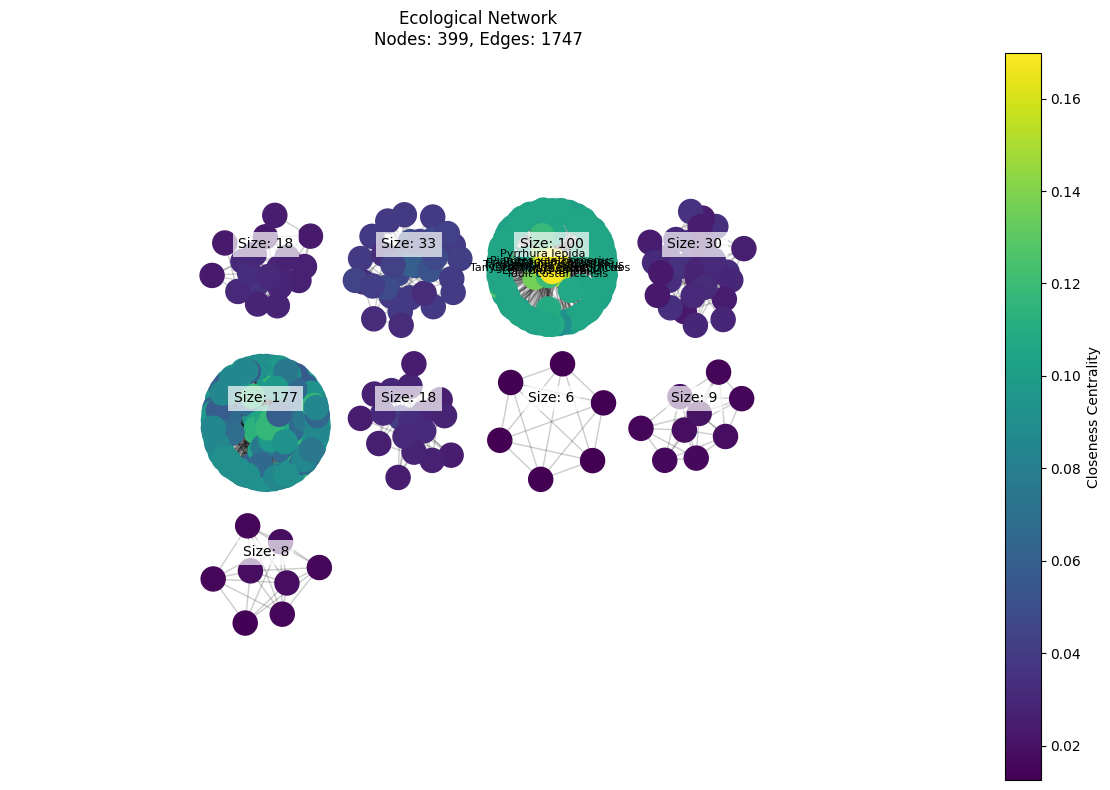

In [179]:
plot_network_closeness(G_eco)

In [180]:
def plot_network_closeness_by_size(G, component_size, top_n=10):
    # Calculate closeness centrality
    closeness = nx.closeness_centrality(G)

    # Get connected components
    components = list(nx.connected_components(G))

    # Find component with specified size
    target_component = None
    for comp in components:
        if len(comp) == component_size:
            target_component = comp
            break

    if target_component is None:
        print(f"No component with size {component_size} found.")
        print("Available component sizes:", [len(comp) for comp in components])
        return

    # Create subgraph of the target component
    subG = G.subgraph(target_component)

    # Calculate layout for the component
    pos = nx.spring_layout(subG, k=1, iterations=50)

    plt.figure(figsize=(10,8))

    # Plot nodes
    nodes = nx.draw_networkx_nodes(subG, pos,
                                 node_color=[closeness[node] for node in subG.nodes()],
                                 cmap=plt.cm.viridis)

    # Plot edges
    nx.draw_networkx_edges(subG, pos, alpha=0.2)

    # Add labels for top nodes in this component
    component_closeness = {node: closeness[node] for node in subG.nodes()}
    top_nodes = dict(sorted(component_closeness.items(),
                          key=lambda x: x[1],
                          reverse=True)[:top_n])
    nx.draw_networkx_labels(subG, pos,
                          {node: node for node in top_nodes.keys()},
                          font_size=8)

    # Add colorbar
    plt.colorbar(nodes, label='Closeness Centrality')

    plt.title(f"Component of Size {component_size}\nNodes: {subG.number_of_nodes()}, Edges: {subG.number_of_edges()}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

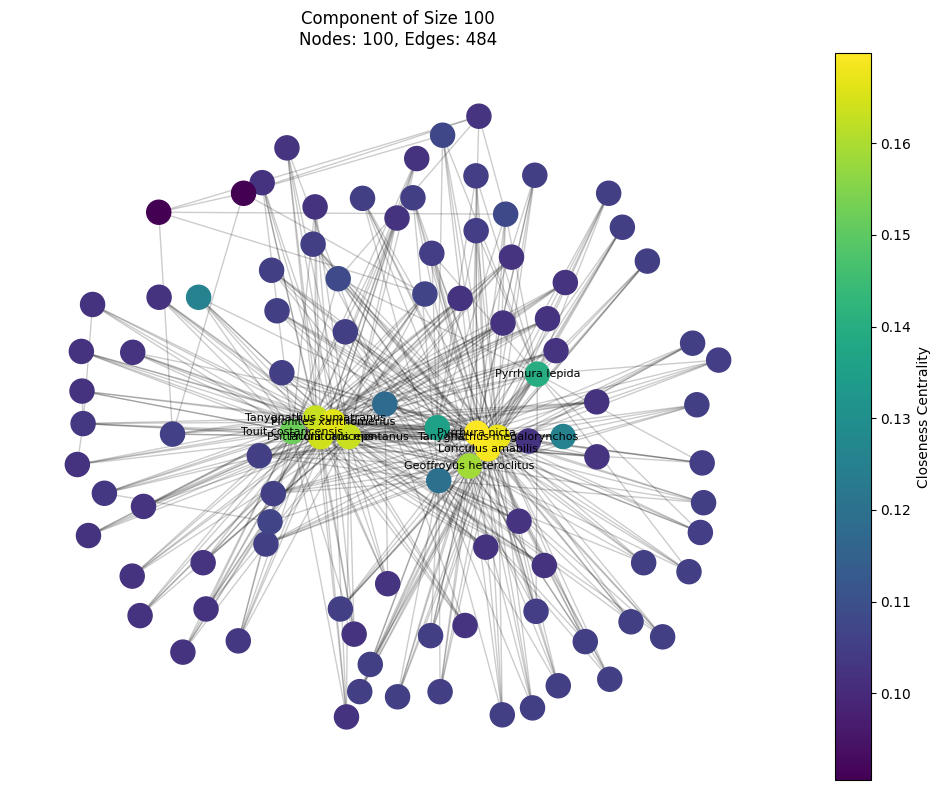

In [181]:
plot_network_closeness_by_size(G_eco, 100)

## Morphological Network

In [182]:
get_top_closeness_nodes(G_morpho)

,closeness
Pezoporus wallicus,0.207311
Cyanoramphus unicolor,0.202758
Cyanoramphus novaezelandiae,0.202241
Pezoporus occidentalis,0.200404
Northiella haematogaster,0.200101
Eunymphicus uvaeensis,0.196729
Cyanoramphus malherbi,0.196049
Eunymphicus cornutus,0.193564
Chalcopsitta duivenbodei,0.191510
Cyanoramphus auriceps,0.190682


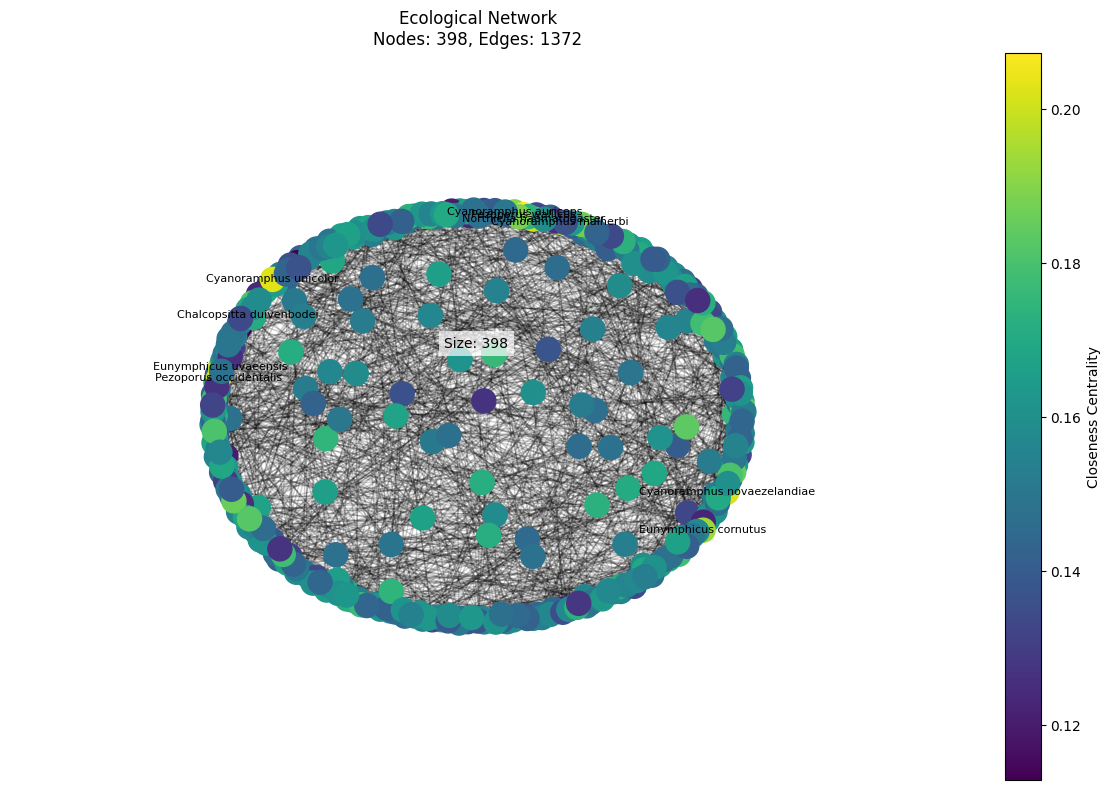

In [183]:
plot_network_closeness(G_morpho)

#Other Metrics

In [184]:
def compare_network_properties(G1, G2, name1="Network 1", name2="Network 2"):
    # Dictionary to store metrics
    metrics = defaultdict(dict)

    # Calculate metrics for both networks
    networks = {name1: G1, name2: G2}

    for name, G in networks.items():
        # Basic network properties
        metrics['Nodes'][name] = G.number_of_nodes()
        metrics['Edges'][name] = G.number_of_edges()
        metrics['Density'][name] = nx.density(G)
        metrics['Average Clustering'][name] = nx.average_clustering(G)

        # Centrality measures
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

        metrics['Avg Degree Centrality'][name] = np.mean(list(degree_centrality.values()))
        metrics['Avg Betweenness Centrality'][name] = np.mean(list(betweenness_centrality.values()))
        metrics['Avg Eigenvector Centrality'][name] = np.mean(list(eigenvector_centrality.values()))

        # Connectivity measures
        try:
            metrics['Average Shortest Path'][name] = nx.average_shortest_path_length(G)
        except:
            metrics['Average Shortest Path'][name] = float('inf')

        metrics['Global Efficiency'][name] = nx.global_efficiency(G)

        # Modularity (using Louvain community detection)
        try:
            communities = nx.community.louvain_communities(G)
            metrics['communities'][name] = communities
            metrics['Number of Communities'][name] = len(communities)
            metrics['Modularity'][name] = nx.community.modularity(G, communities)
        except:
            metrics['Number of Communities'][name] = 0
            metrics['Modularity'][name] = 0

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot for basic metrics
    basic_metrics = ['Density', 'Average Clustering', 'Global Efficiency', 'Modularity']
    x = np.arange(len(basic_metrics))
    width = 0.35

    values1 = [metrics[m][name1] for m in basic_metrics]
    values2 = [metrics[m][name2] for m in basic_metrics]

    ax1.bar(x - width/2, values1, width, label=name1)
    ax1.bar(x + width/2, values2, width, label=name2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(basic_metrics, rotation=45)
    ax1.set_title('Basic Network Metrics')
    ax1.legend()

    # Spider plot for centrality measures
    centrality_metrics = ['Avg Degree Centrality', 'Avg Betweenness Centrality', 'Avg Eigenvector Centrality']
    values1 = [metrics[m][name1] for m in centrality_metrics]
    values2 = [metrics[m][name2] for m in centrality_metrics]

    angles = np.linspace(0, 2*np.pi, len(centrality_metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle
    values1 = np.concatenate((values1, [values1[0]]))
    values2 = np.concatenate((values2, [values2[0]]))

    ax2.plot(angles, values1, 'o-', label=name1)
    ax2.plot(angles, values2, 'o-', label=name2)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(centrality_metrics)
    ax2.set_title('Centrality Measures')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    # Print detailed metrics
    print("\nDetailed Network Metrics:")
    print("-" * 50)
    for metric, values in metrics.items():
        print(f"{metric}:")
        for name, value in values.items():
            if isinstance(value, (int, float)) and metric != 'communities':
                print(f"  {name}: {value:.4f}")
            else:
                print(f"  {name}: {value}")
        print()

    return metrics


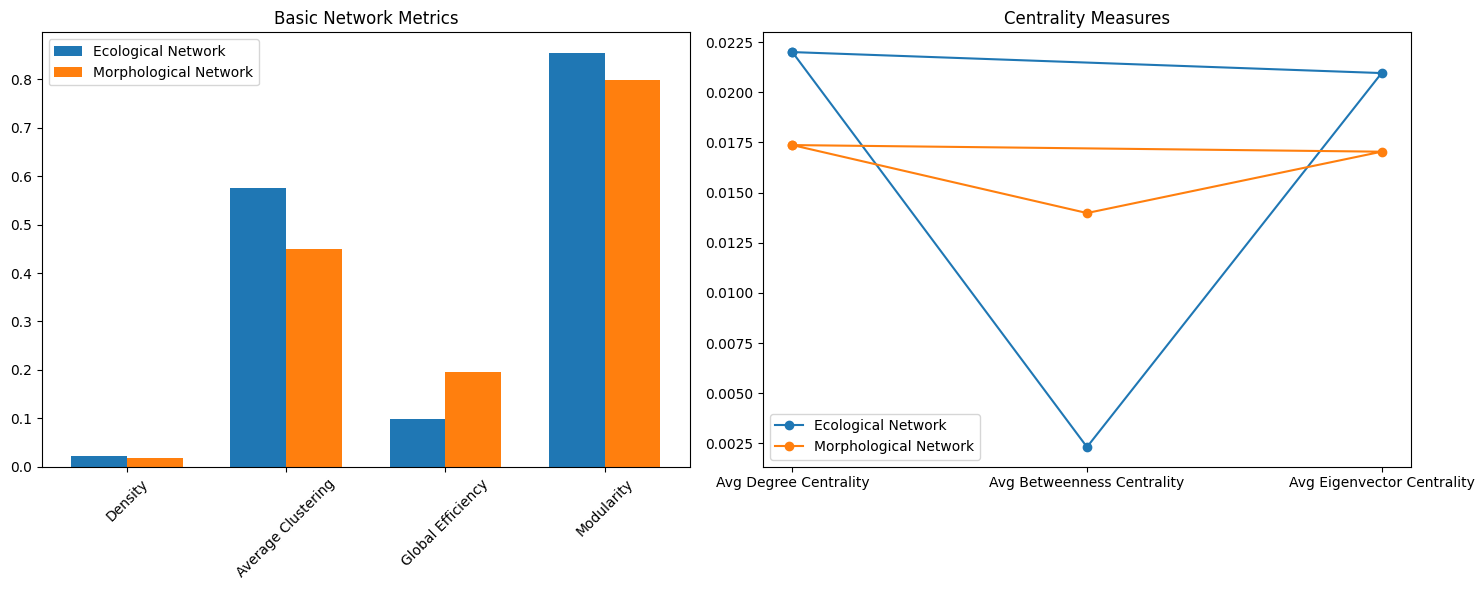


Detailed Network Metrics:
--------------------------------------------------
Nodes:
  Ecological Network: 399.0000
  Morphological Network: 398.0000

Edges:
  Ecological Network: 1747.0000
  Morphological Network: 1372.0000

Density:
  Ecological Network: 0.0220
  Morphological Network: 0.0174

Average Clustering:
  Ecological Network: 0.5746
  Morphological Network: 0.4492

Avg Degree Centrality:
  Ecological Network: 0.0220
  Morphological Network: 0.0174

Avg Betweenness Centrality:
  Ecological Network: 0.0023
  Morphological Network: 0.0140

Avg Eigenvector Centrality:
  Ecological Network: 0.0210
  Morphological Network: 0.0170

Average Shortest Path:
  Ecological Network: inf
  Morphological Network: 6.5355

Global Efficiency:
  Ecological Network: 0.0979
  Morphological Network: 0.1950

communities:
  Ecological Network: [{'Lorius hypoinochrous', 'Psitteuteles goldiei', 'Psitteuteles versicolor', 'Trichoglossus euteles', 'Charmosyna rubronotata', 'Loriculus aurantiifrons', 'Ch

In [185]:
metrics=compare_network_properties(G_eco, G_morpho, "Ecological Network", "Morphological Network")

#Community comparison

In [186]:
eco_communities = metrics["communities"]["Ecological Network"]
morph_communities = metrics["communities"]["Morphological Network"]

In [187]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_community_relationships(eco_communities, morph_communities):
    # Create a matrix to store relationships
    n_eco = len(eco_communities)
    n_morph = len(morph_communities)
    relationship_matrix = np.zeros((n_eco, n_morph))

    # Calculate number of shared nodes for each pair of communities
    for i in range(n_eco):
        for j in range(n_morph):
            # Count the number of shared nodes (intersection)
            shared_nodes = len(eco_communities[i] & morph_communities[j])
            relationship_matrix[i,j] = shared_nodes

     # Visualize relationships
    plt.figure(figsize=(15,10))
    heatmap = sns.heatmap(relationship_matrix,
                         xticklabels=[f'Morph {i+1}' for i in range(n_morph)],
                         yticklabels=[f'Eco {i+1}' for i in range(n_eco)],
                         cmap='viridis',
                         annot=True,    # Show numerical values in cells
                         fmt='.0f')     # Format as whole numbers

    # Add colorbar label
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Number of Shared Nodes', rotation=270, labelpad=25)

    plt.title('Number of Shared Nodes Between Communities')
    plt.xlabel('Morphological Communities')
    plt.ylabel('Ecological Communities')
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

    return relationship_matrix

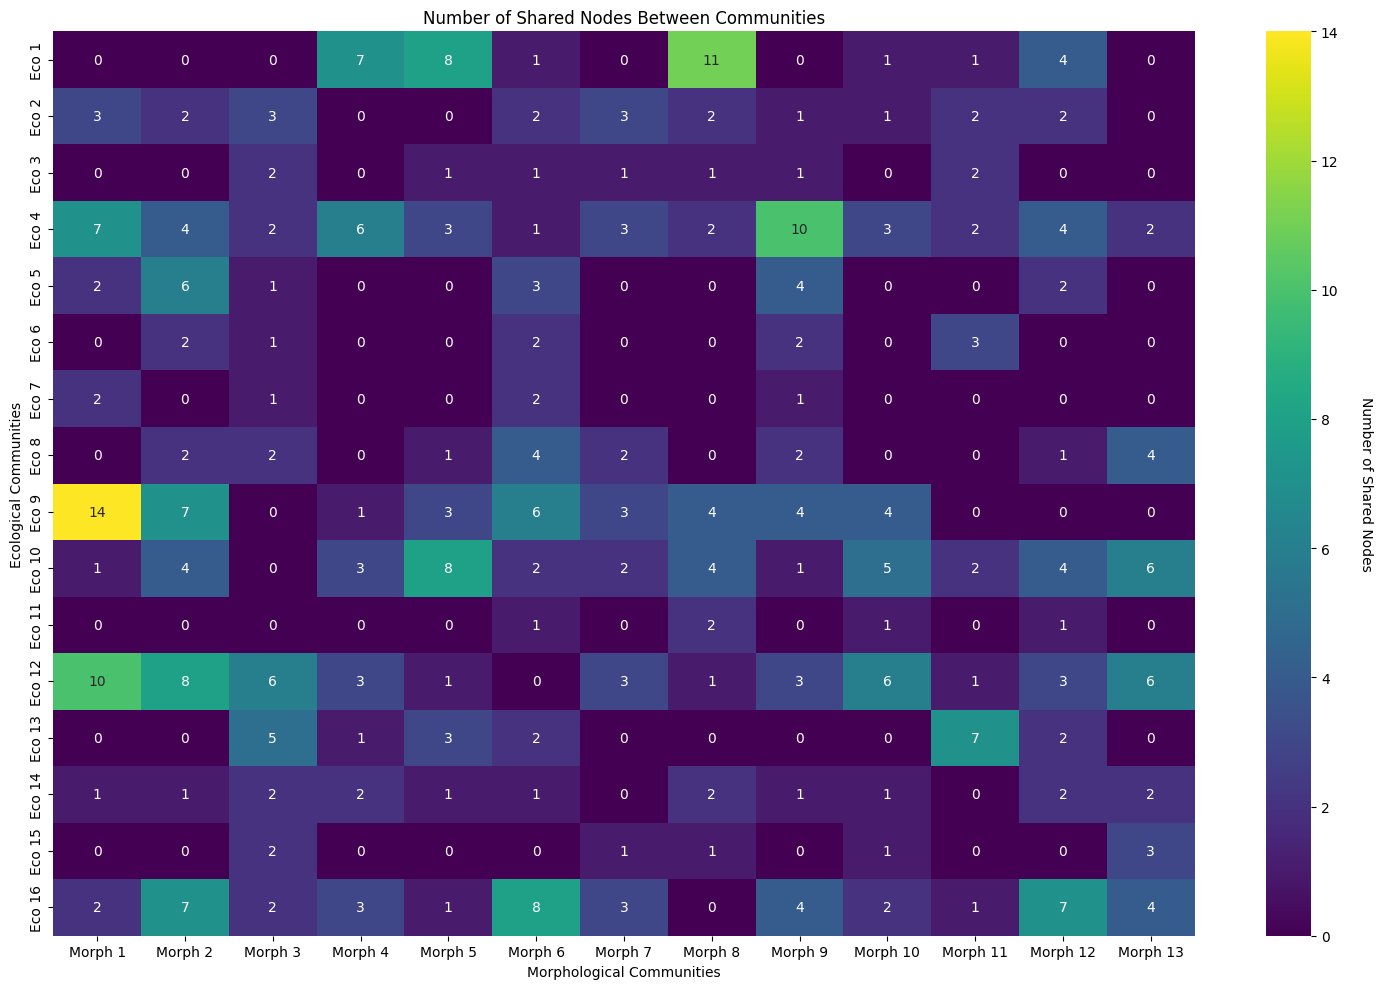

In [188]:
def analyze_community_patterns(eco_communities, morph_communities, relationship_matrix):
    n_eco = len(eco_communities)
    n_morph = len(morph_communities)

    # Find strongest relationships
    max_overlap = np.max(relationship_matrix)
    max_positions = np.where(relationship_matrix == max_overlap)

    # Calculate percentage of non-zero overlaps
    non_zero = np.count_nonzero(relationship_matrix)
    total_pairs = n_eco * n_morph
    overlap_percentage = (non_zero / total_pairs) * 100

    # Find communities with no overlap
    zero_overlaps = np.where(relationship_matrix == 0)

    print(f"Analysis Results:")
    print(f"- Strongest overlap: {max_overlap:.0f} nodes")
    print(f"  Between Eco communities {[i+1 for i in max_positions[0]]} and Morph communities {[i+1 for i in max_positions[1]]}")
    print(f"\n- {overlap_percentage:.1f}% of community pairs share at least one node")
    print(f"- {non_zero} community pairs have overlapping nodes out of {total_pairs} total pairs")

    if len(zero_overlaps[0]) > 0:
        print("\nCommunities with no overlap:")
        for eco, morph in zip(zero_overlaps[0], zero_overlaps[1]):
            print(f"  Eco {eco+1} and Morph {morph+1}")

    # Check for diagonal pattern
    diagonal_sum = np.trace(relationship_matrix)
    off_diagonal_mean = (np.sum(relationship_matrix) - diagonal_sum) / (total_pairs - min(n_eco, n_morph))
    diagonal_mean = diagonal_sum / min(n_eco, n_morph)

    print(f"\nPattern Analysis:")
    print(f"- Average overlap along diagonal: {diagonal_mean:.1f} nodes")
    print(f"- Average overlap off diagonal: {off_diagonal_mean:.1f} nodes")
    if diagonal_mean > off_diagonal_mean:
        print("→ Stronger overlap along diagonal suggests correlation between eco and morph communities")
    else:
        print("→ No clear diagonal pattern, suggesting more complex relationships")

    return {
        'max_overlap': max_overlap,
        'overlap_percentage': overlap_percentage,
        'diagonal_mean': diagonal_mean,
        'off_diagonal_mean': off_diagonal_mean
    }


relationship_matrix = analyze_community_relationships(eco_communities, morph_communities)


In [189]:
patterns = analyze_community_patterns(eco_communities, morph_communities, relationship_matrix)

Analysis Results:
- Strongest overlap: 14 nodes
  Between Eco communities [9] and Morph communities [1]

- 63.0% of community pairs share at least one node
- 131 community pairs have overlapping nodes out of 208 total pairs

Communities with no overlap:
  Eco 1 and Morph 1
  Eco 1 and Morph 2
  Eco 1 and Morph 3
  Eco 1 and Morph 7
  Eco 1 and Morph 9
  Eco 1 and Morph 13
  Eco 2 and Morph 4
  Eco 2 and Morph 5
  Eco 2 and Morph 13
  Eco 3 and Morph 1
  Eco 3 and Morph 2
  Eco 3 and Morph 4
  Eco 3 and Morph 10
  Eco 3 and Morph 12
  Eco 3 and Morph 13
  Eco 5 and Morph 4
  Eco 5 and Morph 5
  Eco 5 and Morph 7
  Eco 5 and Morph 8
  Eco 5 and Morph 10
  Eco 5 and Morph 11
  Eco 5 and Morph 13
  Eco 6 and Morph 1
  Eco 6 and Morph 4
  Eco 6 and Morph 5
  Eco 6 and Morph 7
  Eco 6 and Morph 8
  Eco 6 and Morph 10
  Eco 6 and Morph 12
  Eco 6 and Morph 13
  Eco 7 and Morph 2
  Eco 7 and Morph 4
  Eco 7 and Morph 5
  Eco 7 and Morph 7
  Eco 7 and Morph 8
  Eco 7 and Morph 10
  Eco 7 and Mo

In [190]:


def analyze_distributions(G):


   # Get list of all node degrees in the network
    degrees = [d for _, d in G.degree()]

    # Calculate average degree - will be used as lambda (λ) for Poisson and Exponential
    mean_degree = np.mean(degrees)

    # Calculate empirical degree distribution
    # unique_degrees = all unique k values (list)
    # counts = how many nodes have each degree k (list)
    unique_degrees, counts = np.unique(degrees, return_counts=True)

    # Normalize to get probabilities P(k)
    # This calculates P(k) = (number of nodes with degree k) / (total number of nodes)
    empirical_dist = counts / len(G.nodes())

    # Fit power law
    # This finds optimal γ (gamma) for P(k) ∝ k^(-γ)
    fit = powerlaw.Fit(degrees, discrete=True)

    # Create range of k values for plotting theoretical distributions
    k = np.arange(min(degrees), max(degrees)+1)

    # Calculate Power Law distribution
    # P(k) ∝ k^(-γ)
    power_law = (k/min(degrees))**(-(fit.alpha+1))
    # Normalize to make probabilities sum to 1
    power_law = power_law / sum(power_law)

    # Calculate Poisson distribution
    # P(k) = (λ^k / k!) * e^(-λ)
    # λ = mean_degree
    # Calculate Poisson using scipy.stats
    poisson = stats.poisson.pmf(k, mean_degree)



    # Calculate Exponential distribution
    # P(k) = (1/λ)e^(-k/λ)
    # λ = mean_degree
    exponential = (1/mean_degree) * math.e**(-k/mean_degree)
    # Normalize to make probabilities sum to 1
    exponential = exponential / sum(exponential)

    # Plot
    # Improved plotting code
    plt.figure(figsize=(10, 6))
    plt.scatter(unique_degrees, empirical_dist, alpha=0.5, label='Empirical', s=50)
    plt.plot(k, power_law, '--', label=f'Power Law (γ={fit.alpha:.2f},σ={fit.sigma:.2f})')
    plt.plot(k, poisson, '--', label='Poisson')
    plt.plot(k, exponential, '--', label='Exponential')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-4, 1)

    plt.grid(True, alpha=0.3)
    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    plt.legend()



Calculating best minimal value for power law fit


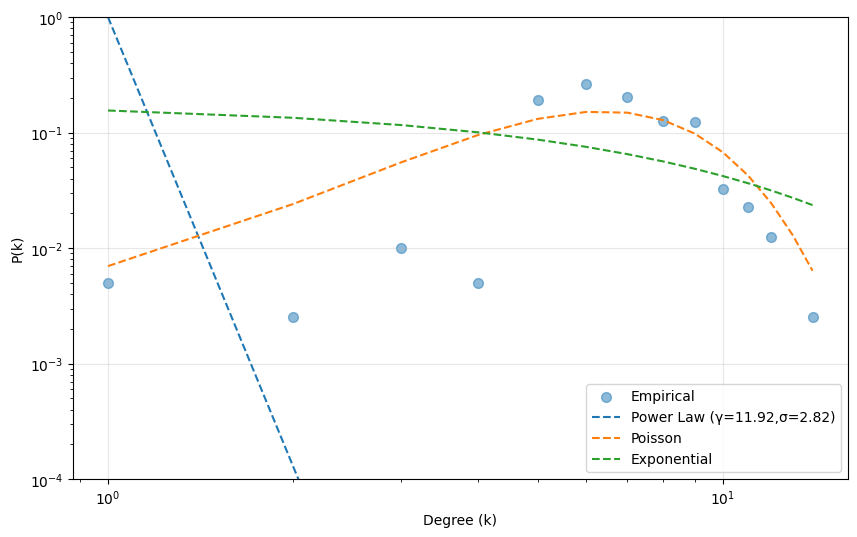

In [191]:
analyze_distributions(G_morpho)

In examining the morphological network where connections between species are based on the similarity of their traits, we observed a degree distribution that approximates a Poisson pattern. This observation suggests that within our network, the distribution of traits among species does not exhibit the extreme variability typical of scale-free networks but rather shows a more uniform spread.

Calculating best minimal value for power law fit


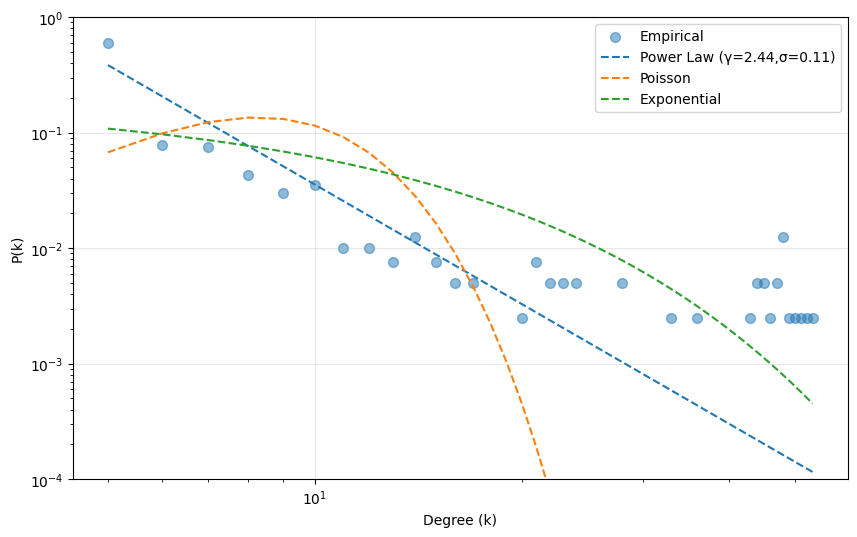

In [192]:
analyze_distributions(G_eco)

In [193]:
def get_extreme_degree_nodes_per_component(G):
    # Get components
    components = list(nx.connected_components(G))

    component_nodes = []

    # For each component
    for component in components:
        # Create subgraph of the component
        subgraph = G.subgraph(component)

        # Get degrees of nodes in this component
        degrees = dict(subgraph.degree())

        # Find node(s) with maximum degree
        max_degree = max(degrees.values())
        max_degree_nodes = [node for node, degree in degrees.items() if degree == max_degree]

        # Find node(s) with minimum degree
        min_degree = min(degrees.values())
        min_degree_nodes = [node for node, degree in degrees.items() if degree == min_degree]

        component_nodes.append({
            'component_size': len(component),
            'max_degree': max_degree,
            'highest_degree_nodes': max_degree_nodes,
            'min_degree': min_degree,
            'lowest_degree_nodes': min_degree_nodes
        })

    # Sort by component size (largest first)
    component_nodes.sort(key=lambda x: x['component_size'], reverse=True)

    # Print results
    print(f"Found {len(components)} components")
    for i, comp in enumerate(component_nodes):
        print(f"\nComponent {i+1} (size: {comp['component_size']})")
        print(f"Highest degree: {comp['max_degree']}")
        print(f"Nodes with highest degree: {comp['highest_degree_nodes']}")
        print(f"Lowest degree: {comp['min_degree']}")
        print(f"Nodes with lowest degree: {comp['lowest_degree_nodes']}")

    return component_nodes

# Usage:
results = get_extreme_degree_nodes_per_component(G_eco)


Found 9 components

Component 1 (size: 177)
Highest degree: 49
Nodes with highest degree: ['Poicephalus robustus']
Lowest degree: 5
Nodes with lowest degree: ['Amazona vinacea', 'Touit batavicus', 'Loriculus catamene', 'Forpus xanthops', 'Psittacus timneh', 'Cyclopsitta coxeni', 'Psilopsiagon aurifrons', 'Charmosyna margarethae', 'Trichoglossus rosenbergii', 'Probosciger aterrimus', 'Ara chloropterus', 'Psittinus cyanurus', 'Trichoglossus meyeri', 'Palaeornis eupatria', 'Forpus spengeli', 'Ara severus', 'Polytelis swainsonii', 'Amazona guildingii', 'Charmosyna multistriata', 'Pyrrhura cruentata', 'Prosopeia personata', 'Himalayapsitta finschii', 'Amazona oratrix', 'Cyclopsitta diophthalma', 'Lorius chlorocercus', 'Cyanoramphus malherbi', 'Pyrilia barrabandi', 'Alexandrinus krameri', 'Poicephalus fuscicollis', 'Diopsittaca nobilis', 'Myiopsitta monachus', 'Pionus menstruus', 'Psittacara finschi', 'Cacatua ducorpsii', 'Pyrilia pyrilia', 'Forpus xanthopterygius', 'Callocephalon fimbriatum

The node with the highest degree from the largest component in the ecological network is the Poicephalus robustus. Many parrots in this component have common combinations of habitat preferences and feeding habits

In [194]:
results = get_extreme_degree_nodes_per_component(G_morpho)

Found 1 components

Component 1 (size: 398)
Highest degree: 14
Nodes with highest degree: ['Psitteuteles goldiei']
Lowest degree: 1
Nodes with lowest degree: ['Geoffroyus hyacinthinus', 'Pionus senilis']


In [197]:
import networkx as nx
import pandas as pd

def identify_network_hubs(G, top_n=10):
    """
    Identify network hubs using multiple centrality metrics
    """
    # Calculate different centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)

    # Create DataFrame with all metrics
    hub_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree_Centrality': [degree_cent[node] for node in G.nodes()],
        'Betweenness_Centrality': [betweenness_cent[node] for node in G.nodes()],
        'Eigenvector_Centrality': [eigenvector_cent[node] for node in G.nodes()]
    })

    # Calculate hub score (average of normalized centrality measures)
    hub_df['Hub_Score'] = hub_df[['Degree_Centrality', 'Betweenness_Centrality', 'Eigenvector_Centrality']].mean(axis=1)

    # Sort by hub score
    hub_df = hub_df.sort_values('Hub_Score', ascending=False)

    # Print top hubs
    print(f"\nTop {top_n} Hubs:")
    print(hub_df.head(top_n))

    # Get node attributes for top hubs
    print(f"\nDetails for top {top_n} hubs:")
    for node in hub_df['Node'].head(top_n):
        print(f"\nSpecies: {node}")
        print("Attributes:", G.nodes[node])

    return hub_df

# For the ecological network
print("Analyzing Ecological Network:")
eco_hubs = identify_network_hubs(G_eco)

# For the morphological network
print("\nAnalyzing Morphological Network:")
morph_hubs = identify_network_hubs(G_morpho)

# Compare hubs between networks
def compare_network_hubs(eco_hubs, morph_hubs, top_n=10):
    """
    Compare top hubs between ecological and morphological networks
    """
    eco_top = set(eco_hubs['Node'].head(top_n))
    morph_top = set(morph_hubs['Node'].head(top_n))

    print("\nHub Comparison:")
    print(f"Hubs in both networks: {eco_top.intersection(morph_top)}")
    print(f"Hubs unique to ecological network: {eco_top - morph_top}")
    print(f"Hubs unique to morphological network: {morph_top - eco_top}")

compare_network_hubs(eco_hubs, morph_hubs)

Analyzing Ecological Network:

Top 10 Hubs:
                          Node  Degree_Centrality  Betweenness_Centrality  \
125             Pyrrhura picta           0.133166                0.011285   
325         Loriculus amabilis           0.130653                0.007909   
314      Pionites xanthomerius           0.125628                0.010765   
324  Tanygnathus megalorynchos           0.128141                0.007144   
294       Prioniturus montanus           0.118090                0.009408   
104        Psittacula caniceps           0.120603                0.006371   
81     Geoffroyus heteroclitus           0.108040                0.009634   
172     Tanygnathus sumatranus           0.118090                0.004683   
180        Touit costaricensis           0.090452                0.003784   
221          Pyrrhura amazonum           0.082915                0.001028   

     Eigenvector_Centrality  Hub_Score  
125                0.274407   0.139619  
325                0.26386

# Conclusion Ecological Network

The fragmented structure of the ecological network reflects how parrots naturally group themselves based on ecological similarities and differences. Specifically, two key parameters dictate the clustering:

Habitat preferences and density - Parrots are grouped based on preferred habitats like forests or grasslands, and population density in those habitats.
Feeding strategies - Parrots also cluster based on dietary habits and food gathering behaviors, creating distinct feeding strategy groups.
This makes sense because species with comparable habitats and feeding patterns are most alike, while those in totally different ecological niches are least alike. So the network's disconnected components mirror real ecological divisions between species.

Overall, this structure demonstrates how ecological traits naturally divide parrot species into biologically meaningful clusters based on their ecological similarities to one another.

# Conclusion Morphological Network


Our analysis of psittaciformes (parrots) shows that there is a weak relationship between the birds' physical characteristics and their ecological roles. This independence between physical form and ecological function is a key aspect of parrot evolution, rather than a random event. We found that parrots with similar appearances can live in very different environments. This suggests that parrots have developed a special way of adapting to their environment.

These results challenge traditional ideas about how form and function relate in evolutionary biology. They also have important implications for both theory and practice.
